In [1]:
%load_ext autoreload

In [32]:
%autoreload 2
from typing import Callable
import math

import jax
import jax.numpy as jnp

from matplotlib import pyplot as plt
from algorithms.ptss.ptss import parallel_tempering_with_slice_sampling

In [33]:
def draw_counter_plot(x, y, z, title="Contour Plot", size=(3, 3)):
    plt.figure(figsize=size)
    contour = plt.contour(x, y, z, levels=15, colors='black', linewidths=0.8)
    plt.clabel(contour, inline=True, fontsize=8) # Add labels to lines

    plt.contourf(x, y, z, levels=15, cmap='RdBu_r', alpha=0.6)

    plt.title(title)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.colorbar(label="Function Value")
    plt.show()


class GMM:
    def __init__(self, r, n_modes, std, seed=0):
        angles = jnp.linspace(0, 2 * math.pi, n_modes, endpoint=False)
        self.means = r * jnp.array([jnp.cos(angles), jnp.sin(angles)]).T
        self.stds = jnp.array([std] * n_modes)
        self.pis = jnp.array([1.0 / n_modes] * n_modes)
        self.key = jax.random.PRNGKey(seed)

    def sample(self, n_samples):
        self.key, subkey = jax.random.split(self.key)
        keys = jax.random.split(subkey, n_samples)
        mode_indices = jax.random.randint(subkey, (n_samples,), 0, len(self.means))

        def sample_one(key, mode_index):
            mean = self.means[mode_index]
            std = self.stds[mode_index]
            return jax.random.normal(key, (2,)) * std + mean

        samples = jax.vmap(sample_one)(keys, mode_indices)
        return samples

    def log_density(self, x):
        x = jnp.expand_dims(x, 1)  # Shape (n_samples, 1, 2)
        means = jnp.expand_dims(self.means, 0)  # Shape (1, n_modes, 2)
        stds = jnp.expand_dims(self.stds, (0, 2))  # Shape (1, n_modes, 1)

        log_pfg = -0.5 * jnp.sum(
            jnp.log(2 * math.pi * stds ** 2) + \
            ((x - means) ** 2) / (stds ** 2), 
            axis=2
        )

        return jax.nn.logsumexp(log_pfg + jnp.log(self.pis[None, :]), axis=1)

    def density(self, x):
        return jnp.exp(self.log_density(x))

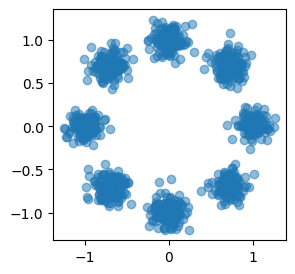

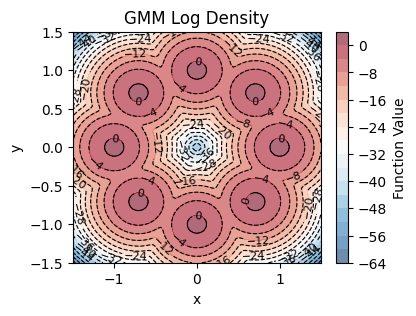

In [34]:
gmm = GMM(r=1.0, n_modes=8, std=0.1, seed=42)
samples = gmm.sample(1000)

plt.figure(figsize=(3, 3))
plt.scatter(*samples.T, alpha=0.5)
plt.show()

x, y = jnp.meshgrid(jnp.linspace(-1.5, 1.5, 100), jnp.linspace(-1.5, 1.5, 100))
X = jnp.stack([x.ravel(), y.ravel()]).T
z = gmm.log_density(X).reshape(x.shape)
draw_counter_plot(x, y, z, title="GMM Log Density", size=(4, 3))

In [57]:
key = jax.random.PRNGKey(0)
x_start = jax.random.normal(key, (500, 2)) * 0.1

temps = jnp.array([1.0, 4.0, 8.0])
chain = parallel_tempering_with_slice_sampling(
    x_start=x_start,
    log_density=gmm.log_density,
    temps=temps, 
    window_size=0.05,
    chain_length=100,
    swap_freq=5,
    alpha=1.0,
    seed=0,
    propose_region_limits=(-2.0, 2.0)
)

Progress: step 5, swap avg: 0.662
Progress: step 10, swap avg: 0.530
Progress: step 15, swap avg: 0.578
Progress: step 20, swap avg: 0.616
Progress: step 25, swap avg: 0.660
Progress: step 30, swap avg: 0.732
Progress: step 35, swap avg: 0.570
Progress: step 40, swap avg: 0.610
Progress: step 45, swap avg: 0.688
Progress: step 50, swap avg: 0.606
Progress: step 55, swap avg: 0.546
Progress: step 60, swap avg: 0.632
Progress: step 65, swap avg: 0.722
Progress: step 70, swap avg: 0.678
Progress: step 75, swap avg: 0.536
Progress: step 80, swap avg: 0.546
Progress: step 85, swap avg: 0.646
Progress: step 90, swap avg: 0.512
Progress: step 95, swap avg: 0.680
Progress: step 100, swap avg: 0.638


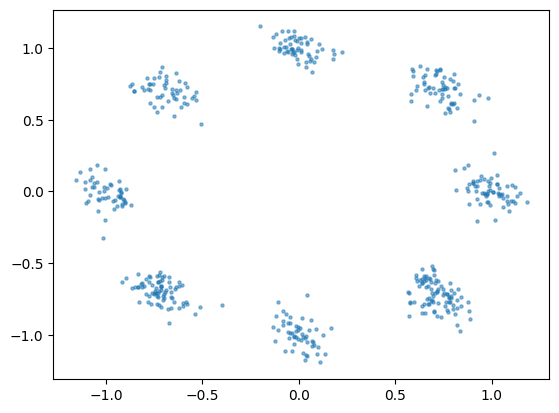

In [60]:
plt.scatter(*chain[-1, 0].T, alpha=0.5, s=5)
# plt.xlim(-1.5, 1.5)
# plt.ylim(-1.5, 1.5)